In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
path = '/content/drive/MyDrive/brain_tumor_dataset'

In [3]:
import tensorflow as tf
from tensorflow.keras import models, layers
import matplotlib.pyplot as plt

In [4]:
img_size = 256
batch_size = 16 
epochs = 50
channels = 3

In [5]:
dataset = tf.keras.preprocessing.image_dataset_from_directory(
    path,
    shuffle=True,
    image_size = (img_size,img_size),
    batch_size = batch_size
)

Found 253 files belonging to 2 classes.


In [6]:
class_names = dataset.class_names
class_names

['no', 'yes']

In [7]:
len(dataset)

16

In [8]:
for image_batch, label_batch in dataset.take(1):
    print(image_batch.shape)
    print(label_batch.numpy())

(16, 256, 256, 3)
[0 1 0 0 0 0 1 0 0 0 0 1 1 1 0 1]


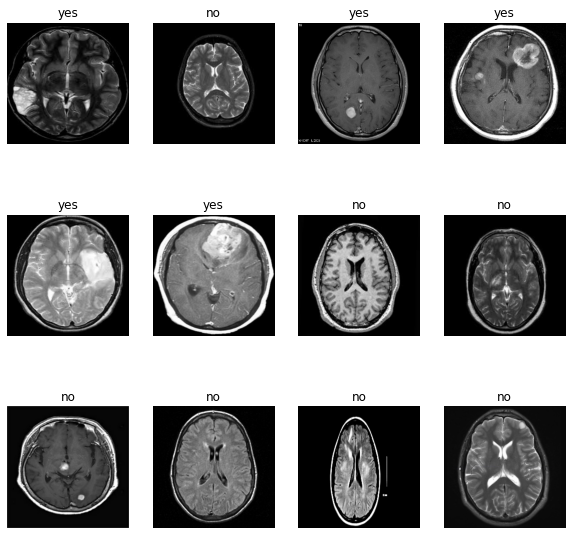

In [9]:
plt.figure(figsize=(10,10))
for image_batch, label_batch in dataset.take(1):
    for i in range(12):
        ax = plt.subplot(3,4,i+1)
        plt.imshow(image_batch[i].numpy().astype('uint8'))
        plt.title(class_names[label_batch[i]])
        plt.axis('off')

In [10]:
train_size = 0.8
len(dataset)*train_size

12.8

In [11]:
train_ds = dataset.take(12)
len(train_ds)

12

In [12]:
test_ds = dataset.skip(12)
len(test_ds)

4

In [13]:
val_ds = test_ds.take(2)
len(val_ds)

2

In [14]:
test_ds = test_ds.skip(2)
len(test_ds)

2

In [15]:
train_ds = train_ds.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)
val_ds = val_ds.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)
test_ds = test_ds.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)

In [16]:
resize_and_rescale = tf.keras.Sequential([
    layers.experimental.preprocessing.Resizing(img_size,img_size),
    layers.experimental.preprocessing.Rescaling(1.0/255)
])

In [17]:
data_augmentation = tf.keras.Sequential([
    layers.experimental.preprocessing.RandomFlip('horizontal_and_vertical'),
    layers.experimental.preprocessing.RandomRotation(0.2)
])

In [18]:
model = models.Sequential([
    resize_and_rescale,
    data_augmentation,
    layers.Conv2D(16, (3,3), activation='relu', input_shape=(batch_size, img_size, img_size, channels)),
    layers.MaxPool2D((2,2)),
    layers.Conv2D(256, (3,3), activation='relu'),
    layers.MaxPool2D((2,2)),
    layers.Conv2D(175, (3,3), activation='relu'),
    layers.MaxPool2D((2,2)),
    layers.Conv2D(100, (3,3), activation='relu'),
    layers.MaxPool2D((2,2)),
    layers.Conv2D(64, (3,3), activation='relu'),
    layers.MaxPool2D((2,2)),
    layers.Conv2D(32, (3,3), activation='relu'),
    layers.MaxPool2D((2,2)),
    layers.Flatten(),
    layers.Dense(32, activation='relu'),
    layers.Dense(2, activation='sigmoid')
])

model.build(input_shape=(batch_size, img_size, img_size, channels))

In [19]:
model.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 sequential (Sequential)     (16, 256, 256, 3)         0         
                                                                 
 sequential_1 (Sequential)   (16, 256, 256, 3)         0         
                                                                 
 conv2d (Conv2D)             (16, 254, 254, 16)        448       
                                                                 
 max_pooling2d (MaxPooling2D  (16, 127, 127, 16)       0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (16, 125, 125, 256)       37120     
                                                                 
 max_pooling2d_1 (MaxPooling  (16, 62, 62, 256)        0         
 2D)                                                  

In [20]:
model.compile(optimizer='adam', 
              loss= tf.keras.losses.SparseCategoricalCrossentropy(from_logits=False),
             metrics=['accuracy']
)

In [21]:
history = model.fit(train_ds,
                    epochs = epochs,
                    batch_size = batch_size,
                    verbose=1,
                    validation_data = val_ds
)

Epoch 1/50
12/12 [==============================] - 45s 235ms/step - loss: 0.6828 - accuracy: 0.6094 - val_loss: 0.6632 - val_accuracy: 0.5625
Epoch 2/50
12/12 [==============================] - 2s 151ms/step - loss: 0.6439 - accuracy: 0.6302 - val_loss: 0.7672 - val_accuracy: 0.5625
Epoch 3/50
12/12 [==============================] - 2s 141ms/step - loss: 0.6611 - accuracy: 0.6302 - val_loss: 0.6711 - val_accuracy: 0.5625
Epoch 4/50
12/12 [==============================] - 2s 142ms/step - loss: 0.6718 - accuracy: 0.6302 - val_loss: 0.6514 - val_accuracy: 0.7188
Epoch 5/50
12/12 [==============================] - 2s 142ms/step - loss: 0.6479 - accuracy: 0.6875 - val_loss: 0.5955 - val_accuracy: 0.7188
Epoch 6/50
12/12 [==============================] - 2s 140ms/step - loss: 0.5783 - accuracy: 0.7240 - val_loss: 0.5542 - val_accuracy: 0.7188
Epoch 7/50
12/12 [==============================] - 2s 141ms/step - loss: 0.5626 - accuracy: 0.7188 - val_loss: 0.5755 - val_accuracy: 0.6875
Epoch

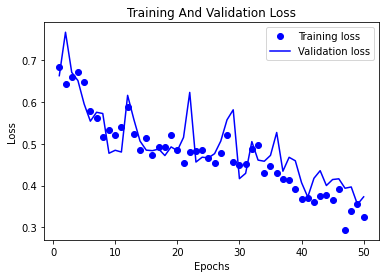

In [22]:
loss = history.history['loss']
val_loss = history.history['val_loss']
epochs = range(1, len(loss) + 1)
plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training And Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

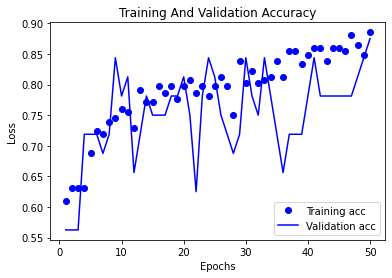

In [23]:
plt.clf()
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
plt.plot(epochs, acc, 'bo', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training And Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

In [24]:
scores = model.evaluate(test_ds)

2/2 [==============================] - 2s 48ms/step - loss: 0.3557 - accuracy: 0.9310
